In [1]:
!pip install mne scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.2 MB/s eta 0:00:00


In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/l1b.gdf"

Mounted at /content/drive


In [4]:
raw = mne.io.read_raw_gdf(file_path, preload=True)

Extracting EDF parameters from /content/drive/My Drive/l1b.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
#  1, #  2, #  3, #  4, #  5, #  6, #  7, #  8, #  9, # 10, # 11, # 12, # 13, # 14, # 15, # 16, # 17, # 18, # 19, # 20, # 21, # 22, # 23, # 24, # 25, # 26, # 27, # 28, # 29, # 30, # 31, # 32, # 33, # 34, # 35, # 36, # 37, # 38, # 39, # 40, # 41, # 42, # 43, # 44, # 45, # 46, # 47, # 48, # 49, # 50, # 51, # 52, # 53, # 54, # 55, # 56, # 57, # 58, # 59, # 60
Creating raw.info structure...
Reading 0 ... 633429  =      0.000 ...  2533.716 secs...


In [5]:
events, _ = mne.events_from_annotations(raw)


Used Annotations descriptions: [np.str_('1023'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772'), np.str_('783'), np.str_('785'), np.str_('786')]


In [6]:
event_id = {'left_hand': 769, 'right_hand': 770, 'feet': 771, 'tongue': 772}
event_id = {'left_hand': 3, 'right_hand': 4, 'feet': 5, 'tongue': 6}

In [7]:
raw.filter(7., 35., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.8s finished


<RawGDF | l1b.gdf, 60 x 633430 (2533.7 s), ~290.0 MiB, data loaded>

In [8]:
tmin= 2.0
tmax= 5.0

In [9]:
epochs = mne.Epochs (raw, events, event_id, tmin, tmax, baseline=None, preload=True, event_repeated='drop')

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 751 original time points ...
0 bad epochs dropped


In [10]:
X = epochs.get_data()

In [11]:

y = epochs.events[:, -1]-3

In [12]:
csp = CSP(n_components=22, reg='ledoit_wolf', log=True, norm_trace=True)

In [13]:
X_csp = csp.fit_transform(X, y)
print("Shape des caractéristiques CSP :", X_csp.shape)

Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 60 dim * 9.1e+09  max singular value)
    Estimated rank (data): 60
    data: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Estimating class=2 covariance using LEDOIT_WOLF
Done.
Estimating class=3 covariance using LEDOIT_WOLF
Done.
Shape des caractéristiques CSP : (120, 22)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
clf = SVC(kernel='rbf')

In [16]:
clf.fit(X_train, y_train)

SVC()

In [17]:

train_accuracy = clf.score(X_train, y_train)

In [18]:
test_accuracy = clf.score(X_test, y_test)

In [19]:
print("Train Accuracy: %.2f%%" % (train_accuracy * 100))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100))

Train Accuracy: 96.88%
Test Accuracy: 95.83%


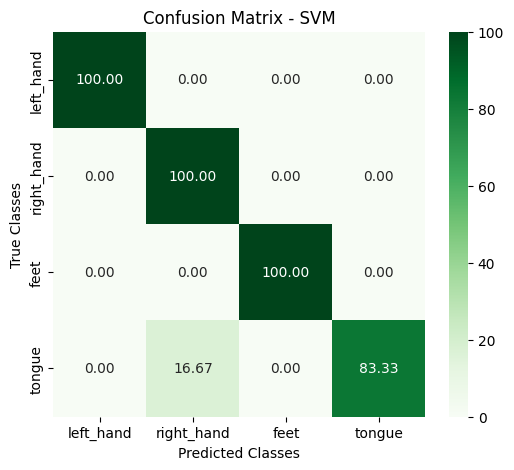

In [22]:

# Supposons que votre classificateur SVM s'appelle clf_svm
from sklearn.svm import SVC
clf_svm = SVC()  # vous pouvez spécifier kernel='linear', 'rbf', etc. selon votre cas
clf_svm.fit(X_train, y_train)  # entraînement

# Prédictions sur l'ensemble de test
y_pred = clf_svm.predict(X_test)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Conversion en pourcentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=event_id, yticklabels=event_id)
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix - SVM")
plt.show()
